<a href="https://colab.research.google.com/github/LuBly/Knowledge_Distillation/blob/main/Resnet18_BaseLine_KD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import Library For Create Resnet Layer model& Data Load



In [7]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as torch_models
import torch.nn.functional as F
import torch.optim as optim

Import Library For Training and Display Chart

In [8]:
import os
import copy
import time
import matplotlib.pyplot as plt
%matplotlib inline

Resnet Model 생성
1. Residual block 정의

In [9]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

2. Resnet Model 구현

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

Model check_BaseLine

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_S = resnet18().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model_S(x)
print(output.size())

torch.Size([3, 10])


In [12]:
summary(model_S, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

가중치 초기화 함수

In [13]:
# weight initialization
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

Data Load

1. Batch size 128
2. Batch size 64
3. Batch size 32

In [14]:
dataset_dir='./data'
batch_size=128
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
simple_transform = transforms.Compose([transforms.ToTensor(), normalize])

train_transform = simple_transform

trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True,
download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False,
download=True, transform=simple_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
pin_memory=True, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
pin_memory=True, shuffle=False)

  

print("CIFAR10")
print("---"*20)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR10
------------------------------------------------------------


모델 학습 함수
1. Learning Rate 0.01 
2. Learning Rate 0.001
3. Learning Rate 0.1
->사실상 lr scheduler에 의해 조절된다. epoch가 늘어나면 해결되는 현상.

Colab설정상 많은 epoch를 실행시킬 수 없으므로, patience를 낮춰 조절해본다.

In [15]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model_S.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

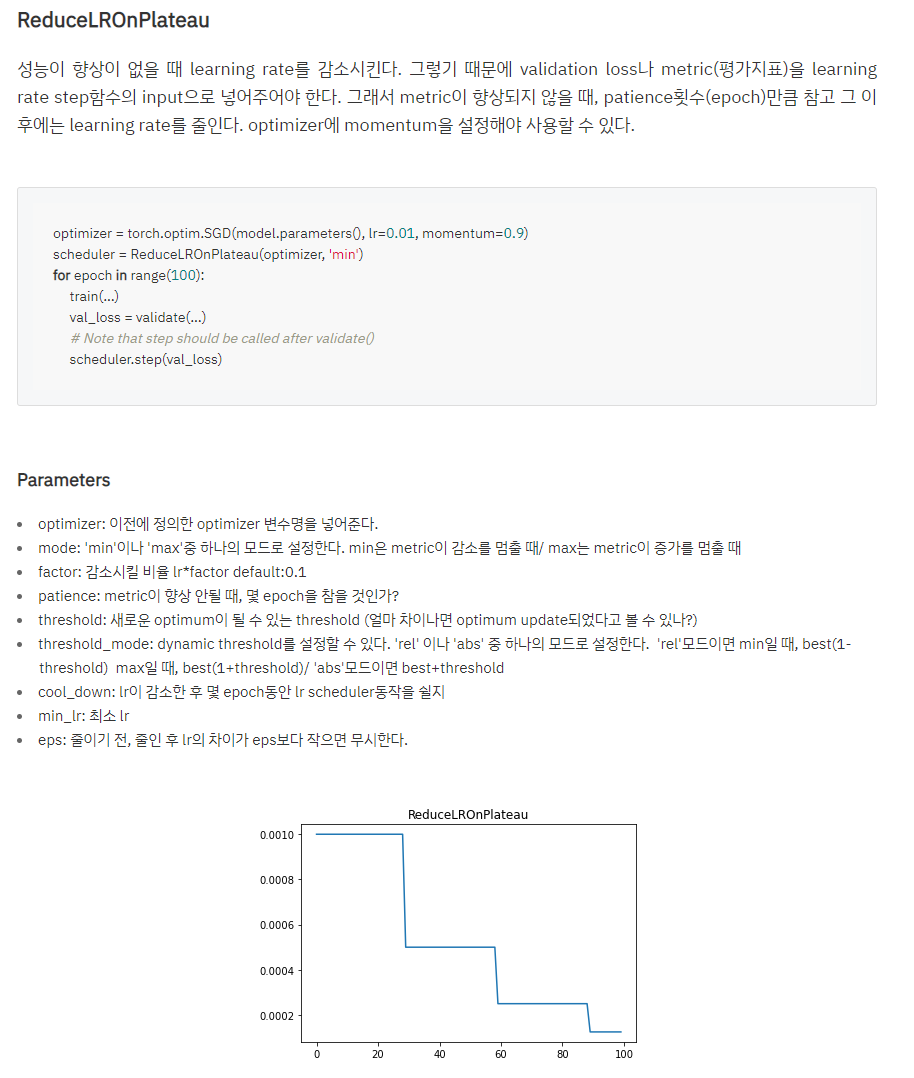

In [16]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [17]:
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [18]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [19]:
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

학습 parameter 설정

In [20]:
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'val_dl':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

Student(BaseLine) 학습 시작

In [21]:
model_S.apply(initialize_weights);

In [22]:
model_S, loss_hist, metric_hist = train_val(model_S, params_train)

Epoch 0/29, current lr= 0.01
Copied best model weights!
train loss: 1.711388, val loss: 1.579254, accuracy: 44.68, time: 0.7500 min
----------
Epoch 1/29, current lr= 0.01
Copied best model weights!
train loss: 1.204777, val loss: 1.073261, accuracy: 62.23, time: 1.5000 min
----------
Epoch 2/29, current lr= 0.01
Copied best model weights!
train loss: 0.965355, val loss: 0.959381, accuracy: 65.98, time: 2.2499 min
----------
Epoch 3/29, current lr= 0.01
train loss: 0.815599, val loss: 1.024058, accuracy: 66.49, time: 2.9925 min
----------
Epoch 4/29, current lr= 0.01
Copied best model weights!
train loss: 0.706647, val loss: 0.839292, accuracy: 71.60, time: 3.7467 min
----------
Epoch 5/29, current lr= 0.01
Copied best model weights!
train loss: 0.607139, val loss: 0.791368, accuracy: 73.42, time: 4.5064 min
----------
Epoch 6/29, current lr= 0.01
Copied best model weights!
train loss: 0.514596, val loss: 0.778673, accuracy: 74.45, time: 5.2585 min
----------
Epoch 7/29, current lr= 0.

BaseLine Chart

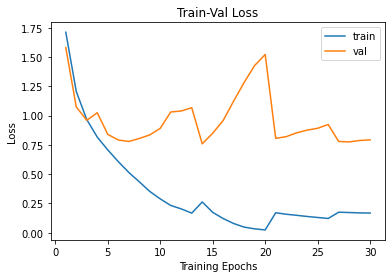

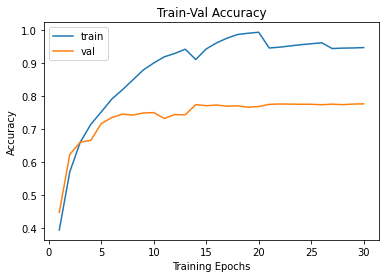

In [23]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

Model check_Teacher

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_T = resnet50().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model_T(x)
print(output.size())

torch.Size([3, 10])


In [25]:
summary(model_T, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

model_T weight 초기화

In [26]:
model_T.apply(initialize_weights);

In [27]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model_T.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

Teacher 학습을 위한 parameter 정의

In [28]:
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'val_dl':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [29]:
model_T, loss_hist, metric_hist = train_val(model_T, params_train)

Epoch 0/29, current lr= 0.01
Copied best model weights!
train loss: 2.539323, val loss: 2.305625, accuracy: 32.82, time: 1.4360 min
----------
Epoch 1/29, current lr= 0.01
Copied best model weights!
train loss: 1.541639, val loss: 1.482956, accuracy: 48.08, time: 2.8614 min
----------
Epoch 2/29, current lr= 0.01
Copied best model weights!
train loss: 1.491801, val loss: 1.389734, accuracy: 49.97, time: 4.2921 min
----------
Epoch 3/29, current lr= 0.01
Copied best model weights!
train loss: 1.316408, val loss: 1.368121, accuracy: 52.01, time: 5.7188 min
----------
Epoch 4/29, current lr= 0.01
train loss: 1.199183, val loss: 1.495461, accuracy: 46.91, time: 7.1442 min
----------
Epoch 5/29, current lr= 0.01
Copied best model weights!
train loss: 1.195044, val loss: 1.138292, accuracy: 59.85, time: 8.5713 min
----------
Epoch 6/29, current lr= 0.01
Copied best model weights!
train loss: 1.016069, val loss: 1.032868, accuracy: 62.99, time: 10.0000 min
----------
Epoch 7/29, current lr= 0

Teacher Model Chart

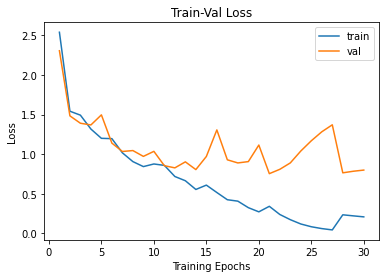

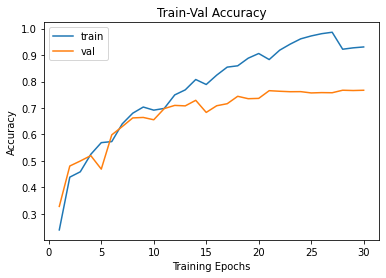

In [30]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

Student Model 학습

1. 가중치 초기화_BaseLine check를 위해 사용했던 model_S(Student)의 weight 초기화

In [31]:
model_S.apply(initialize_weights);

2. Teacher model학습을 통해 얻은 Weight값(Soft Label들을 Load)

In [32]:
# load weight
model_T.load_state_dict(torch.load('/content/models/teacher_weights.pt'))

# optimizer
opt = optim.Adam(model_S.parameters())

3. KD 함수 선언 및 적용

In [33]:
# knowledge distillation loss
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

In [34]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

4. 30 epoch로 학습시도

In [35]:
num_epochs= 30

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    model_S.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(trainloader.dataset)

    for xb, yb in trainloader:
        xb = xb.to(device)
        yb = yb.to(device)

        output = model_S(xb)
        teacher_output = model_T(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    model_S.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(model_S, loss_func, testloader)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/29, current lr= 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


train loss: 0.003996, val loss: 0.005729, accuracy: 77.50, time: 1.0507 min
----------
Epoch 1/29, current lr= 0.001
train loss: 0.002480, val loss: 0.005637, accuracy: 77.94, time: 2.1020 min
----------
Epoch 2/29, current lr= 0.001
train loss: 0.002076, val loss: 0.005759, accuracy: 77.93, time: 3.1598 min
----------
Epoch 3/29, current lr= 0.001
train loss: 0.001813, val loss: 0.005727, accuracy: 77.78, time: 4.2156 min
----------
Epoch 4/29, current lr= 0.001
train loss: 0.001680, val loss: 0.005603, accuracy: 78.65, time: 5.2733 min
----------
Epoch 5/29, current lr= 0.001
train loss: 0.001500, val loss: 0.005672, accuracy: 78.58, time: 6.3244 min
----------
Epoch 6/29, current lr= 0.001
train loss: 0.001380, val loss: 0.005768, accuracy: 78.22, time: 7.3759 min
----------
Epoch 7/29, current lr= 0.001
train loss: 0.001308, val loss: 0.005876, accuracy: 78.54, time: 8.4267 min
----------
Epoch 8/29, current lr= 0.001
train loss: 0.001244, val loss: 0.005847, accuracy: 78.43, time:

KD Result Check

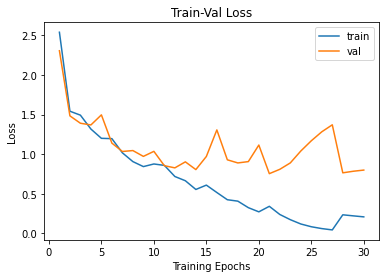

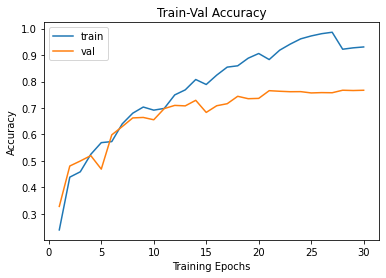

In [36]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

Reference
1. https://sanghyu.tistory.com/113